In [1]:
# Install pytorch-tabnet
!pip install pytorch-tabnet

# Install LightGBM
!pip install lightgbm

# Optional: Install scikit-learn-contrib for any additional functionalities
!pip install scikit-learn-contrib

# Install dask-expr
!pip install dask-expr

# Install imbalanced-learn for SMOTE (if not already installed)
!pip install imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.8 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement scikit-learn-contrib (from versions: none)
ERROR: No matching distribution found for scikit-learn-contrib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.2 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.10.0
    Uninstalling dask-2024.10.0:
      Successfully uninstalled dask-2024.10.0


In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Traditional ML
import lightgbm as lgb

# Deep Learning Model
from pytorch_tabnet.tab_model import TabNetClassifier

# Explainable AI
import shap

# Meta-Learner
from sklearn.linear_model import LogisticRegression

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# For model saving and loading
import joblib

# Import torch for TabNet
import torch

In [2]:
# Replace 'fetal_health.csv' with your actual file path if different
data = pd.read_csv('/content/fetal_health.csv')

# Display the first five rows to verify
print("First five rows of the dataset:")
print(data.head())

# Check the shape of the dataset
print(f"Dataset Shape: {data.shape}")


First five rows of the dataset:
   baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0 

In [3]:
# Features to drop based on SHAP importance
features_to_drop = [
    'fetal_movement',
    'histogram_width',
    'histogram_max',
    'mean_value_of_long_term_variability',
    'histogram_number_of_peaks',
    'light_decelerations',
    'histogram_tendency',
    'histogram_number_of_zeroes',
    'severe_decelerations',
    # Optional: Uncomment the following lines to drop additional low-importance features
    'baseline value',
    'histogram_min'
]

# Drop the specified features
data_dropped = data.drop(columns=features_to_drop)

# Verify the remaining features
print("\nFeatures after dropping less important ones:")
print(data_dropped.columns.tolist())

# Check the new shape of the dataset
print(f"\nNew Dataset Shape after dropping features: {data_dropped.shape}")



Features after dropping less important ones:
['accelerations', 'uterine_contractions', 'prolongued_decelerations', 'abnormal_short_term_variability', 'mean_value_of_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'histogram_mode', 'histogram_mean', 'histogram_median', 'histogram_variance', 'fetal_health']

New Dataset Shape after dropping features: (2126, 11)


In [4]:
# Convert 'fetal_health' to integer
data_dropped['fetal_health'] = data_dropped['fetal_health'].astype(int)

# Mapping numerical classes to descriptive labels
health_mapping = {1: 'Normal', 2: 'Suspect', 3: 'Pathological'}
data_dropped['fetal_health_label'] = data_dropped['fetal_health'].map(health_mapping)

# Features (all columns except 'fetal_health' and 'fetal_health_label')
X = data_dropped.drop(['fetal_health', 'fetal_health_label'], axis=1)

# Target variable
y = data_dropped['fetal_health']

# Display the first five rows after dropping features
print("\nFirst five rows after dropping features:")
print(data_dropped.head())


First five rows after dropping features:
   accelerations  uterine_contractions  prolongued_decelerations  \
0          0.000                 0.000                       0.0   
1          0.006                 0.006                       0.0   
2          0.003                 0.008                       0.0   
3          0.003                 0.008                       0.0   
4          0.007                 0.008                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0                             73.0                                   0.5   
1                             17.0                                   2.1   
2                             16.0                                   2.1   
3                             16.0                                   2.4   
4                             16.0                                   2.4   

   percentage_of_time_with_abnormal_long_term_variability  histogram_mode  \
0              

In [6]:
# Handling imbalanced data
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks

# Initialize ADASYN with 'auto' strategy to resample all classes
adasyn = ADASYN(sampling_strategy='auto', random_state=42)

# Apply ADASYN to the dataset
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

# Initialize Tomek Links
tomek = TomekLinks()

# Apply Tomek Links to clean the dataset
X_resampled, y_resampled = tomek.fit_resample(X_adasyn, y_adasyn)

# Display the shape of the resampled dataset and class distribution
print(f"\nResampled X shape after ADASYN + Tomek Links: {X_resampled.shape}")
print(f"Resampled y distribution after ADASYN + Tomek Links:\n{y_resampled.value_counts()}")


Resampled X shape after ADASYN + Tomek Links: (4883, 10)
Resampled y distribution after ADASYN + Tomek Links:
fetal_health
3    1651
1    1642
2    1590
Name: count, dtype: int64


In [7]:
# Split the resampled data (70% train, 30% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Display the shapes of the training and testing sets
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")



Training set shape: (3418, 10)
Testing set shape: (1465, 10)


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# Verify scaling by checking min and max values
print("\nMin of Scaled Training Features (Should be 0):")
print(X_train_scaled.min())

print("\nMax of Scaled Training Features (Should be 1):")
print(X_train_scaled.max())



Min of Scaled Training Features (Should be 0):
accelerations                                             0.0
uterine_contractions                                      0.0
prolongued_decelerations                                  0.0
abnormal_short_term_variability                           0.0
mean_value_of_short_term_variability                      0.0
percentage_of_time_with_abnormal_long_term_variability    0.0
histogram_mode                                            0.0
histogram_mean                                            0.0
histogram_median                                          0.0
histogram_variance                                        0.0
dtype: float64

Max of Scaled Training Features (Should be 1):
accelerations                                             1.0
uterine_contractions                                      1.0
prolongued_decelerations                                  1.0
abnormal_short_term_variability                           1.0
mean_value_of_short_t

In [10]:
# Adjust the target values so they start from 0
y_train = y_train - 1
y_test = y_test - 1

# Display the adjusted target distributions
print("\nAdjusted y_train distribution:")
print(pd.Series(y_train).value_counts())

print("\nAdjusted y_test distribution:")
print(pd.Series(y_test).value_counts())



Adjusted y_train distribution:
fetal_health
2    1156
0    1149
1    1113
Name: count, dtype: int64

Adjusted y_test distribution:
fetal_health
2    495
0    493
1    477
Name: count, dtype: int64


In [11]:
# Initialize the TabNet Classifier
tabnet_classifier = TabNetClassifier(
    n_d=64,                # Dimension of the decision step
    n_a=64,                # Dimension of the attention step
    n_steps=5,             # Number of steps in the architecture
    gamma=1.3,             # Relaxation parameter
    lambda_sparse=1e-3,    # Sparse regularization
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax', # "sparsemax" or "entmax"
    verbose=1
)

# Train the TabNet model on the resampled and scaled training data
tabnet_classifier.fit(
    X_train=X_train_scaled.values,
    y_train=y_train.values,
    eval_set=[(X_train_scaled.values, y_train.values), (X_test_scaled.values, y_test.values)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=128
)


epoch 0  | loss: 0.91487 | train_accuracy: 0.57899 | valid_accuracy: 0.57474 |  0:00:01s
epoch 1  | loss: 0.48413 | train_accuracy: 0.42422 | valid_accuracy: 0.41229 |  0:00:03s
epoch 2  | loss: 0.42313 | train_accuracy: 0.53511 | valid_accuracy: 0.51877 |  0:00:04s
epoch 3  | loss: 0.39257 | train_accuracy: 0.55559 | valid_accuracy: 0.53447 |  0:00:06s
epoch 4  | loss: 0.35431 | train_accuracy: 0.5825  | valid_accuracy: 0.55904 |  0:00:08s
epoch 5  | loss: 0.37443 | train_accuracy: 0.49941 | valid_accuracy: 0.48123 |  0:00:10s
epoch 6  | loss: 0.30289 | train_accuracy: 0.4883  | valid_accuracy: 0.47577 |  0:00:12s
epoch 7  | loss: 0.28794 | train_accuracy: 0.54593 | valid_accuracy: 0.53174 |  0:00:14s
epoch 8  | loss: 0.25687 | train_accuracy: 0.52458 | valid_accuracy: 0.52014 |  0:00:18s
epoch 9  | loss: 0.25969 | train_accuracy: 0.57109 | valid_accuracy: 0.54881 |  0:00:19s
epoch 10 | loss: 0.26555 | train_accuracy: 0.57841 | valid_accuracy: 0.56177 |  0:00:22s
epoch 11 | loss: 0.24


TabNet Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.91      0.95       493
     Suspect       0.89      0.94      0.92       477
Pathological       0.95      0.98      0.97       495

    accuracy                           0.94      1465
   macro avg       0.94      0.94      0.94      1465
weighted avg       0.95      0.94      0.94      1465



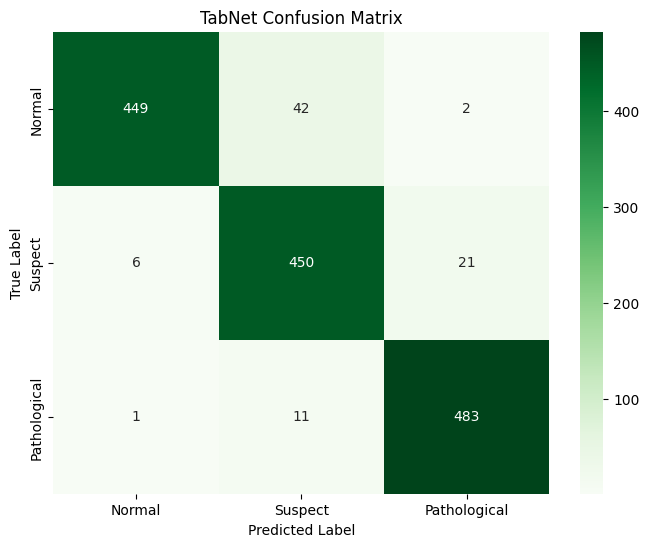

In [12]:
# Make predictions on the test set
y_pred_tabnet = tabnet_classifier.predict(X_test_scaled.values)

# Evaluate TabNet performance
print("\nTabNet Classification Report:")
print(classification_report(y_test, y_pred_tabnet, target_names=['Normal', 'Suspect', 'Pathological']))

# Confusion Matrix for TabNet
conf_matrix_tabnet = confusion_matrix(y_test, y_pred_tabnet)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tabnet, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Suspect', 'Pathological'],
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.title('TabNet Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Extract feature importances using SHAP
print("\nGenerating SHAP values for TabNet...")
explainer = shap.Explainer(tabnet_classifier)
shap_values = explainer(X_test_scaled.values)

# SHAP Summary Plot
print("\nGenerating SHAP Summary Plot for TabNet...")
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, show=False)
plt.title('SHAP Summary Plot for TabNet')
plt.tight_layout()
plt.show()

# Check the type and structure of shap_values
print(f"Type of shap_values: {type(shap_values)}")